In [1]:
import os
import csv
import re
import pandas as pd
import matplotlib.pyplot as plt
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import textstat
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
scaler = StandardScaler()

# Load the English language model
nlp = spacy.load("en_core_web_sm")

In [2]:
# This code block gives the comments in a formatted way which lets us convert to a dataframe
def get_comments(filepath):
    comments = []
    with open(filepath, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('#'):
                comments.append(line)
            else:
                break 
    return comments

def extract_info(comment):
    # Regular expression to extract difficulty, result, and tests from comments
    pattern = r"#\s+(\d+\.\d+)\s+(.+?)\s+(\d+/\d+)"

    match = re.match(pattern, comment)
    if match:
        return match.groups()
    return None

def find_gpt_files(directory):
    gpt_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file == 'gpt.py':
                gpt_files.append(os.path.join(root, file))
    return gpt_files

def save_comments_to_csv(comments, filename):
    with open(filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["Difficulty", "Result", "Tests"])
        for comment in comments:
            info = extract_info(comment)
            if info:
                writer.writerow(info)

def main():
    kattis_dir = os.path.join(os.getcwd(), 'kattis')
    gpt_files = find_gpt_files(kattis_dir)
    all_comments = []

    for filepath in gpt_files:
        comments = get_comments(filepath)
        all_comments.extend(comments)

    if all_comments:
        csv_filename = 'kattis_comments.csv'
        save_comments_to_csv(all_comments, csv_filename)
        print(f"Comments saved to CSV file: {csv_filename}")
    else:
        print("No comments found in any gpt.py files.")

if __name__ == "__main__":
    main()

Comments saved to CSV file: kattis_comments.csv


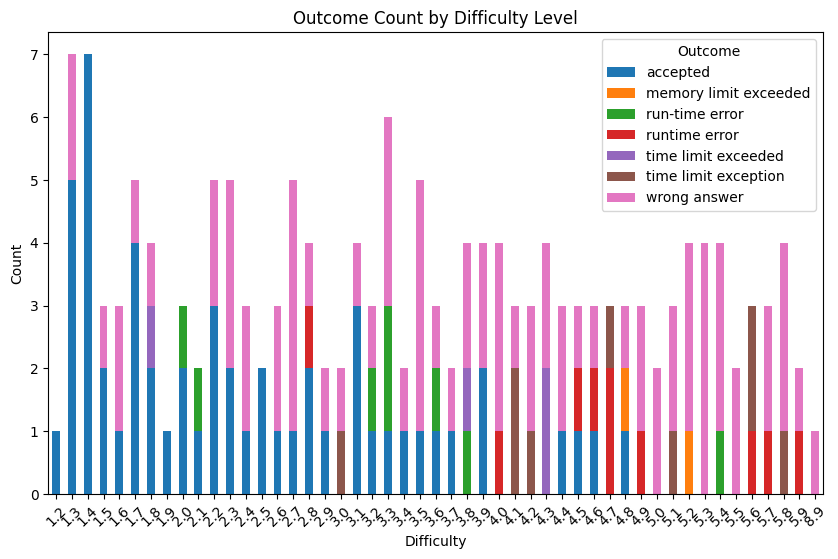

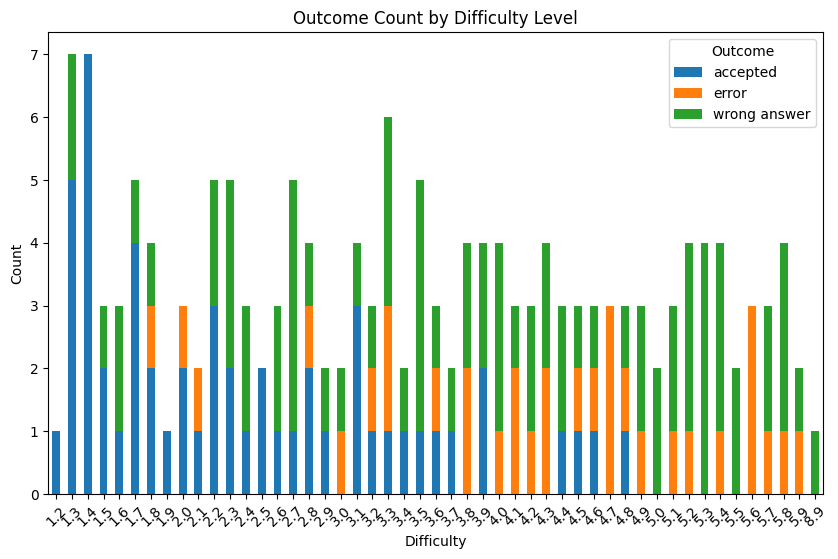

In [3]:
# Creating a dataframe from the comments csv
df_kattis = pd.read_csv("./kattis_comments.csv")
df_kattis['Result'] = df_kattis['Result'].apply(lambda x: x.lower() if isinstance(x, str) else x)

# Creating more columns for splitting the tests 
df_kattis[['Correct', 'Total']] = df_kattis['Tests'].str.split('/',expand=True).astype(int)

# Getting the count of each result at the difficulties
grouped = df_kattis.groupby(['Difficulty','Result']).size().unstack(fill_value=0)
# display(grouped)

# Creating a stacked bar chart for each result at each difficulty
ax = grouped.plot(kind='bar', stacked=True, figsize=(10, 6))
ax.set_xlabel('Difficulty')
ax.set_ylabel('Count')
ax.set_title('Outcome Count by Difficulty Level')
plt.xticks(rotation=45)
plt.legend(title='Outcome')
plt.show()

# making all errors to be a general error and plotting again
df_kattis['Result'] = df_kattis['Result'].apply(lambda x: 'error' if isinstance(x, str) and x.lower().split()[-1] in ['error', 'exceeded', 'exception'] else x)

# Getting the count of each result at the difficulties
grouped = df_kattis.groupby(['Difficulty','Result']).size().unstack(fill_value=0)
# Creating a stacked bar chart for each result at each difficulty
ax = grouped.plot(kind='bar', stacked=True, figsize=(10, 6))
ax.set_xlabel('Difficulty')
ax.set_ylabel('Count')
ax.set_title('Outcome Count by Difficulty Level')
plt.xticks(rotation=45)
plt.legend(title='Outcome')
plt.show()
# Figure out which feutures to have as inputs in a prediction model, Figure engineering. With what to get from the problem statements. Readability, frequency of words, etc. think of meaningful features. perform unsupervised learning, understanding the features.

In [4]:
df_kattis

,Difficulty,Result,Tests,Correct,Total
0,3.0,wrong answer,1/19,1,19
1,3.3,error,0/3,0,3
2,2.7,wrong answer,2/19,2,19
3,4.0,wrong answer,0/13,0,13
4,2.0,accepted,52/52,52,52
...,...,...,...,...,...
159,5.3,wrong answer,0/47,0,47
160,5.4,wrong answer,0/22,0,22
161,5.4,error,0/27,0,27
162,4.7,error,0/71,0,71


## Collecting Prompts

In [5]:
# Functions to get all problems
def find_prompt_files(directory):
    prompt_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if 'gpt_prompt' in file:  # Check if 'gpt_prompt' is in the file name
                prompt_files.append(os.path.join(root, file))
    return prompt_files

def get_problem(filepath):
    with open(filepath, 'r') as f:
        problem = f.read().strip()
    return [problem]

kattis_dir = os.path.join(os.getcwd(), 'kattis')
prompt_files = find_prompt_files(kattis_dir)
all_problems = []

for filepath in prompt_files:
    comments = get_problem(filepath)
    all_problems.extend(comments)

all_problems[0]


'2048 is a single-player puzzle game created by Gabriele Cirulli1. It is played on a 4x4  grid that contains integers >=2 that are powers of 2. The player can use a keyboard arrow key (left/up/right/down) to move all the tiles simultaneously. Tiles slide as far as possible in the chosen direction until they are stopped by either another tile or the edge of the grid. If two tiles of the same number collide while moving, they will merge into a tile with the total value of the two tiles that collided. The resulting tile cannot merge with another tile again in the same move. Please observe this merging behavior carefully in all Sample Inputs and Outputs.\n\nInput\nThe input is always a valid game state of a 2048 puzzle. The first four lines of input, that each contains four integers, describe the 16 integers in the 4x4 grid of 2048 puzzle. The j-th integer in the i-th line denotes the content of the cell located at the i-th row and the j-th cell. For this problem, all integers in the input

In [6]:
 # Look into another filter for words that are important
data = []
terms = set()
with open("programming_terms.txt", "r") as file:
    for line in file:
        # Split the line into terms using comma as delimiter
        term_list = line.strip().lower().split(',')
        # Add each term to the set
        for term in term_list:
            terms.add(term.strip())

for problem in all_problems[:20]:
        doc = nlp(problem)
        # Extract keywords (nouns and verbs) excluding stopwords
        keywords = [token.text.lower() for token in doc if token.text.lower() not in STOP_WORDS
                    and token.text.lower() in terms
                    and token.pos_ not in ['SYM', 'PUNCT', 'SPACE', 'X']]
        # Count the frequency of each keyword
        keyword_freq = Counter(keywords)
        # Print the top keywords and their frequencies
        data.append(keyword_freq)

df = pd.DataFrame(data)
df = df.fillna(0)
df

,integer,binary,class,implementation,string,algorithm,protocol,testing,variable,stack
0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,3.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,1.0,3.0,2.0,1.0,1.0,0.0,0.0
8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0


In [7]:
# Do all textstat readability and find best features from them
with open("output.csv", mode="w", newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["ARI", "DCR", "DCR_V2", "FRE", "FKG", "SMOG", "CLI", "LINSEAR", "GF", "Textstd", "LexCount", "Difficult Words"])

    for problem in all_problems:
        ARI = textstat.automated_readability_index(problem)
        DCR = textstat.dale_chall_readability_score(problem)
        DCR_v2 = textstat.dale_chall_readability_score_v2(problem)
        FRE = textstat.flesch_reading_ease(problem)
        FKG = textstat.flesch_kincaid_grade(problem)
        SMOG = textstat.smog_index(problem)
        CLI = textstat.coleman_liau_index(problem)
        LINSEAR = textstat.linsear_write_formula(problem)
        GF = textstat.gunning_fog(problem)
        txtstd = textstat.text_standard(problem, float_output=False)
        lex_count = textstat.lexicon_count(problem, removepunct=True)
        difficult_words = textstat.difficult_words(problem)
        info = ARI, DCR, DCR_v2, FRE, FKG, SMOG, CLI, LINSEAR, GF, txtstd, lex_count, difficult_words
        writer.writerow(info)
        



## Kmeans Cluster

Text(0, 0.5, 'Inertia')

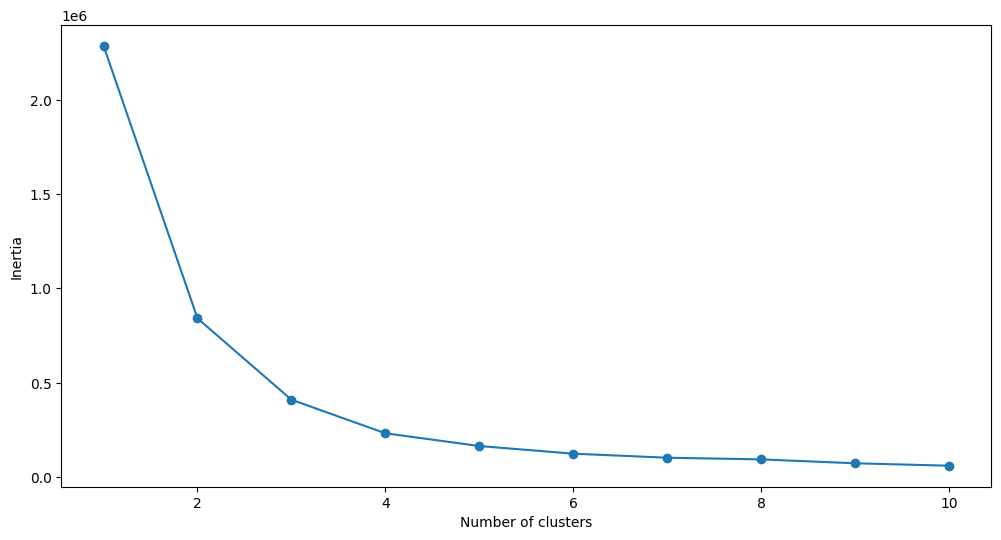

In [8]:
# Adopt one-hot encoding for y values: wrong, accepted, error
# cross-validation techniques
# grid search: model training

#creating dataframe from features
features = pd.read_csv("./output.csv")

# Adding problem difficulties to features
features['Difficulty'] = df_kattis['Difficulty']

# Check unique values in the 'Textstd' column
unique_values = features['Textstd'].unique()

# Representing textstd numerically using a map
textstd_map = {
    '3rd and 4th grade': 1,
    '4th and 5th grade': 2, 
    '5th and 6th grade': 3,
    '6th and 7th grade': 4,
    '7th and 8th grade': 5,
    '8th and 9th grade': 6,
    '9th and 10th grade': 7,
    '10th and 11th grade': 8, 
    '11th and 12th grade': 9,
    '12th and 13th grade': 10,
    '18th and 19th grade': 11,
}
features['Textstd'] = features['Textstd'].map(textstd_map)

X = features.values

inertia_values = []

# Trying to find optimal k value
k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, init='k-means++')
    kmeans.fit(X)
    inertia_values.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,11), 'Inertia values':inertia_values})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['Inertia values'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

Selected Features: 4


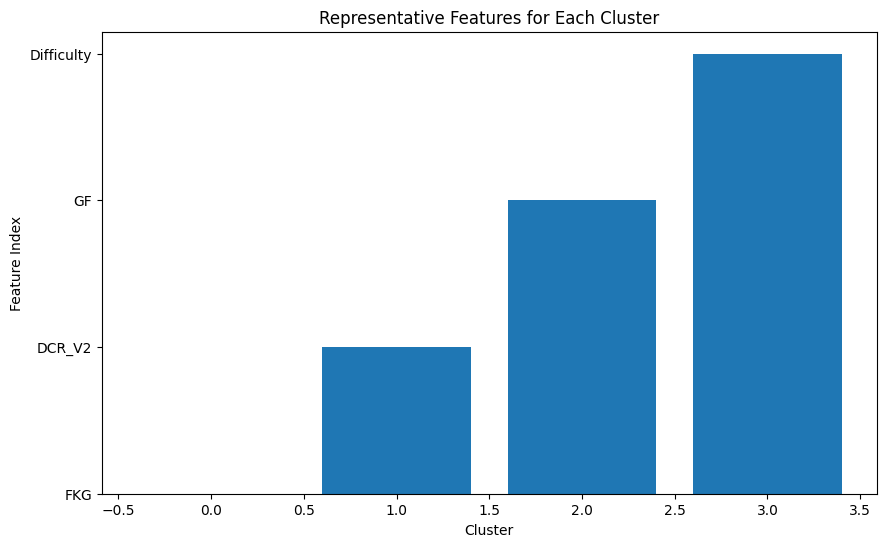

In [9]:
k = 4
kmeans = KMeans(n_clusters=k, init='k-means++')
kmeans.fit(X)

# Get cluster labels for each feature
feature_clusters = kmeans.labels_

# Select one representative feature from each cluster
representative_features = []
for cluster_id in range(k):
    cluster_indices = [i for i, cluster_label in enumerate(feature_clusters) if cluster_label == cluster_id and i < len(features.columns)]
    if len(cluster_indices) > 0:
        cluster_features = features.iloc[:, cluster_indices]
        cluster_center_label = cluster_features.mean(axis=0).idxmin()  # Select feature closest to cluster center (label)
        cluster_center_index = features.columns.get_loc(cluster_center_label)  # Convert label to integer index
        representative_features.append(features.columns[cluster_center_index])


# Select the representative features
selected_features = features[representative_features]

print("Selected Features:", selected_features.shape[1])

plt.figure(figsize=(10, 6))
plt.bar(range(len(representative_features)), representative_features)
plt.xlabel('Cluster')
plt.ylabel('Feature Index')
plt.title('Representative Features for Each Cluster')
plt.show()

In [10]:
# Creating a loop to find which feature are most represent clusters
k = 4
num_runs = 10
feature_counts = Counter()
for _ in range(num_runs):
    kmeans = KMeans(n_clusters=k, init='k-means++')
    kmeans.fit(X)

# Get cluster labels for each feature
    feature_clusters = kmeans.labels_
    representative_features = []
    for cluster_id in range(k):
        cluster_indices = [i for i, cluster_label in enumerate(feature_clusters) if cluster_label == cluster_id and i < len(features.columns)]
        if len(cluster_indices) > 0:
            cluster_features = features.iloc[:, cluster_indices]
            cluster_center_label = cluster_features.mean(axis=0).idxmin()  # Select feature closest to cluster center (label)
            cluster_center_index = features.columns.get_loc(cluster_center_label)  # Convert label to integer index
            representative_features.append(features.columns[cluster_center_index])
    for feature in representative_features:
        feature_counts[feature] += 1
        
print("Feature Counts:")
for feature, count in feature_counts.items():
  print(f"{feature}: {count} appearances")

# Important features from kmeans cluster: Difficulty, DCR_V2, GF, these three always appear with max count, fkg and textstd follow behind them

Feature Counts:
Difficulty: 10 appearances
DCR_V2: 10 appearances
GF: 10 appearances
FKG: 10 appearances


## Logistic Regression 

In [11]:
rep_features = features[['DCR_V2','GF','Difficulty','Textstd', 'FKG']]
rep_features['Result'] = df_kattis['Result']

encoder = OneHotEncoder()
result_encoded = encoder.fit_transform(rep_features[['Result']])

# Convert the sparse matrix to a DataFrame
result_df = pd.DataFrame.sparse.from_spmatrix(result_encoded, columns=encoder.categories_[0])

# Concatenate the one-hot encoded target variable with the original DataFrame
df_encoded = pd.concat([rep_features, result_df], axis=1)

# Drop the original 'Result' column
df_encoded.drop('Result', axis=1, inplace=True)

#print(df_encoded)

scaled_df = scaler.fit_transform(df_encoded.drop(['accepted', 'wrong answer', 'error'], axis=1))
scaled_df = pd.DataFrame(scaled_df, columns=df_encoded.drop(['accepted', 'wrong answer', 'error'], axis=1).columns)

X = scaled_df.values
y = df_encoded[['accepted', 'wrong answer', 'error']].values  # Target variable

# Creating the training, testing, and validation sets
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Print the shapes of the resulting datasets
print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)

# Create a logistic regression model
model = LogisticRegression(max_iter=1000)  

# Convert the one-hot encoded target variable to a 1D array
y_train_labels = y_train.argmax(axis=1)

# Train the model on the training set
model.fit(X_train, y_train_labels)

# Make predictions on the validation set
y_val_pred = model.predict(X_val)

y_val_labels = y_val.argmax(axis=1)

# Evaluate the model on the validation set
val_accuracy = accuracy_score(y_val_labels, y_val_pred)
print("Validation Accuracy:", val_accuracy)

# Print classification report for the validation set
print("Classification Report for Validation Set:")
print(classification_report(y_val_labels, y_val_pred))


Training set: (98, 5) (98, 3)
Validation set: (33, 5) (33, 3)
Test set: (33, 5) (33, 3)
Validation Accuracy: 0.5757575757575758
Classification Report for Validation Set:
              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.45      0.82      0.58        11
           2       0.50      0.20      0.29        10

    accuracy                           0.58        33
   macro avg       0.61      0.56      0.54        33
weighted avg       0.62      0.58      0.56        33



C:\Users\jobri\AppData\Local\Temp\ipykernel_5860\3654298044.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rep_features['Result'] = df_kattis['Result']
